# Navigation


### 1. Start the Environment

The next code cell installs a few packages to set up the environment. It takes a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.4 which is incompatible.


In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

There are 4 possible actions and states have length 37

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Training Procedure

We define here a function to train Agents. The agent we are using, a Rainbow agent, will be imported from file dqn_agent.py.

In [15]:
from collections import deque
import torch
import matplotlib.pylab as plt
from dqn_agent import AgentRainbow

In [16]:
def dqntrain(agent, n_episodes=2000, max_t=1000, 
        eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning training procedure.
    
    Input parameters
       - n_episodes (int): maximum number of training episodes
       - max_t (int): maximum number of timesteps per episode
       - eps_start (float): starting value of epsilon, for epsilon-greedy action selection
       - eps_end (float): minimum value of epsilon
       - eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        # We start the episode
        env_info = env.reset(train_mode=True)[brain_name]
        # state = env.reset()
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            # Obtain the action from our agent
            action = agent.act(state, eps)
            # Act on the environment
            env_info = env.step(action)[brain_name]
            # Obtain information from the game
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            
            # We update the agent
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            # If finished break
            if done:
                break 
        # Statistics        
        scores_window.append(score)       # save for averaged score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        # If target reached, finish
        if np.mean(scores_window)>=15.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_online.state_dict(), 'checkpoint.pth')
            break
        # Make episodes longer when the network is trained
        if i_episode %400 == 0:
            max_t += 200
    return scores

For this particular game it makes things simpler if we train it first with short episodes and we increase the length when the network has already learned a bit how to play

## 4. Instantiate Agent

We start an agent with 4 layers and tuning some parameters 

In [17]:
agentrainbow = AgentRainbow(state_size=37, action_size=4, 
              seed=1021, nu = [32,64,64, 64], e = 1e-3, alpha = 0.25)

In [18]:
score = dqntrain(agentrainbow, 2000, max_t = 400)

Episode 100	Average Score: 0.83
Episode 200	Average Score: 3.23
Episode 300	Average Score: 7.31
Episode 400	Average Score: 11.27
Episode 500	Average Score: 12.43
Episode 600	Average Score: 14.03
Episode 683	Average Score: 15.00
Environment solved in 583 episodes!	Average Score: 15.00


The agent solved the problem in less than 600 episodes (the target was 13 although it was only stopped when it reached 15). We save the checkpoint in a different file

In [20]:
torch.save(agentrainbow.qnetwork_online.state_dict(), 'rainbow-15.pth')

## 5. Score vs number of episodes

Here we plot the averaged score, over a window of 100 episodes, as a function the number of episodes

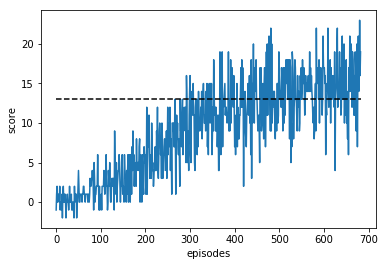

In [21]:
xt = np.arange(len(score))
plt.plot(xt,score)
plt.plot(xt,xt*0+13., 'k--')

plt.xlabel('episodes')
plt.ylabel('score')
plt.savefig('score.png',dpi = 300, tight_layout = True)

In [22]:
np.savetxt('score.dat', score)

## 6. Closing the environment

In [23]:
env.close()